In [1]:
import glob
import os
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import time
import datetime
%matplotlib inline

from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

## Read the original data from 1979-2021

In [2]:
data = pd.read_csv(r'Ag')
df_ori = data[["Date", "Name", "value"]].rename({'value': "Visit"}, axis = 1)

# Convert Date from object to Date type
df_ori['Date'] = pd.to_datetime(df_ori['Date'])
# set Date as index
df_ori = df_ori.set_index(df_ori.Date)
# Drop Date column
df_ori.drop('Date', axis= 1, inplace= True)
df_ori.head()

,Name,Visit
Date,,
1979-01-01,Acadia NP,6011
1979-02-01,Acadia NP,5243
1979-03-01,Acadia NP,11165
1979-04-01,Acadia NP,219351
1979-05-01,Acadia NP,339416


## Read all forecast files from Arima

In [3]:
df_forecast = pd.concat(map(pd.read_csv, glob.glob(os.path.join('', "F:\CSE 6242\Project\output\*.csv"))))

df_forecast = df_forecast.rename({'Unnamed: 0': 'Date', "Visit" : "Visit_Forecast"}, axis = 1)

# Convert Date from object to Date type
df_forecast['Date'] = pd.to_datetime(df_forecast['Date'])
# set Date as index
df_forecast = df_forecast.set_index(df_forecast.Date)
# Drop Date column
df_forecast.drop('Date', axis= 1, inplace= True)

df_forecast.Name = df_forecast.Name.astype("string")

df_forecast.head()

,Name,Visit_Forecast,UCI,LCI
Date,,,,
2019-01-01,Acadia NP,11437.453954,123021.752348,-99355.893020
2019-02-01,Acadia NP,11832.929664,144394.968614,-98971.544662
2019-03-01,Acadia NP,22711.711976,200381.072073,-55044.300085
2019-04-01,Acadia NP,72668.385994,363680.584362,100877.785431
2019-05-01,Acadia NP,232279.184897,603727.651221,336374.141456


In [208]:
df_forecast.to_csv(r"F:\CSE 6242\Project\Forecast_Combined_All Park_2019_2023.csv")

## Reread data for error calculation

In [110]:
df_forecast= pd.read_csv(r"F:\CSE 6242\Project\Forecast_Combined_All Park_2019_2023.csv")

In [111]:
df_ori.head()

,Name,Visit
Date,,
1979-01-01,Acadia NP,6011
1979-02-01,Acadia NP,5243
1979-03-01,Acadia NP,11165
1979-04-01,Acadia NP,219351
1979-05-01,Acadia NP,339416


## Calculate Error of Forecast

### Extract data for Year 2019 from original data

In [112]:
mask1 = (df_ori.index >= "2019-01-01") & (df_ori.index <= "2019-12-01")
df1 = df_ori[mask1]
df1.head()

,Name,Visit
Date,,
2019-01-01,Acadia NP,8532
2019-02-01,Acadia NP,9154
2019-03-01,Acadia NP,20161
2019-04-01,Acadia NP,68046
2019-05-01,Acadia NP,226156


### Extract data for Year 2019 from Forecasting data

In [113]:
# Convert Date from object to Date type
df_forecast['Date'] = pd.to_datetime(df_forecast['Date'])
# set Date as index
df_forecast = df_forecast.set_index(df_forecast.Date)
# Drop Date column
df_forecast.drop('Date', axis= 1, inplace= True)
df_forecast.head()

,Name,Visit_Forecast,UCI,LCI
Date,,,,
2019-01-01,Acadia NP,11437.45395,123021.7523,-99355.89302
2019-02-01,Acadia NP,11832.92966,144394.9686,-98971.54466
2019-03-01,Acadia NP,22711.71198,200381.0721,-55044.30009
2019-04-01,Acadia NP,72668.38599,363680.5844,100877.78540
2019-05-01,Acadia NP,232279.18490,603727.6512,336374.14150


In [114]:
mask2 = (df_forecast.index >= "2019-01-01") & (df_forecast.index <= "2019-12-01")
df2 = df_forecast[mask2].drop(["UCI", "LCI"], axis = 1)
df2.head()

,Name,Visit_Forecast
Date,,
2019-01-01,Acadia NP,11437.45395
2019-02-01,Acadia NP,11832.92966
2019-03-01,Acadia NP,22711.71198
2019-04-01,Acadia NP,72668.38599
2019-05-01,Acadia NP,232279.18490


In [115]:
df1["Visit_Forecast"] = df2["Visit_Forecast"]
df1.head()

,Name,Visit,Visit_Forecast
Date,,,
2019-01-01,Acadia NP,8532,11437.45395
2019-02-01,Acadia NP,9154,11832.92966
2019-03-01,Acadia NP,20161,22711.71198
2019-04-01,Acadia NP,68046,72668.38599
2019-05-01,Acadia NP,226156,232279.18490


In [116]:
MAPE = []
MAE = []
MAD = []
MFE = []
TS = []
park = []

for parkname in (df1.Name.unique()):
    df = df1[df1["Name"] == parkname]
    park. append(parkname)
    
    # MAPE
    MAPE.append(np.mean(np.abs(df.Visit - df.Visit_Forecast)/np.abs(df.Visit)))  
    
    # MAD: Mean Absolute Deviation
    MAD.append(((np.abs(df.Visit - df.Visit_Forecast)).sum()/12).astype(int))
    
    # MFE: Mean Forecast Error (Bias)
    MFE.append((((df.Visit - df.Visit_Forecast)).sum()/12).astype(int))
    # MAE
    MAE.append(np.mean(np.abs(df.Visit - df.Visit_Forecast)))
    

In [117]:
Forecast_Error = pd.DataFrame(list(zip(park, MAPE, MAD, MFE, MAE )),\
                        columns =['Name','MAPE', 'MAD', 'MFE', 'MAE']) 
mask = (Forecast_Error.MAPE <= 0.5)
Forecast_Error = Forecast_Error[mask]
Forecast_Error = Forecast_Error[~Forecast_Error.isin([np.nan, np.inf, -np.inf]).any(1)]
Forecast_Error.head(4)

,Name,MAPE,MAD,MFE,MAE
0,Acadia NP,0.096017,11450,4909,11450.100553
1,Arches NP,0.104733,6072,65,6072.113171
2,Badlands NP,0.101909,5257,-3997,5257.842192
3,Big Bend NP,0.132683,5671,3502,5671.389147


In [119]:
Forecast_Error.MAPE.mean()

0.17848386315844317

In [120]:
Forecast_Error.to_csv(r"F:\CSE 6242\Project\Forecast_Error_2019.csv")

### Example plot of Acadia National Park with forecast data

In [121]:
aca_forecast = df_forecast[df_forecast.Name == "Acadia NP"].drop("Name", axis = 1)
aca_forecast.head()

,Visit_Forecast,UCI,LCI
Date,,,
2019-01-01,11437.45395,123021.7523,-99355.89302
2019-02-01,11832.92966,144394.9686,-98971.54466
2019-03-01,22711.71198,200381.0721,-55044.30009
2019-04-01,72668.38599,363680.5844,100877.78540
2019-05-01,232279.18490,603727.6512,336374.14150


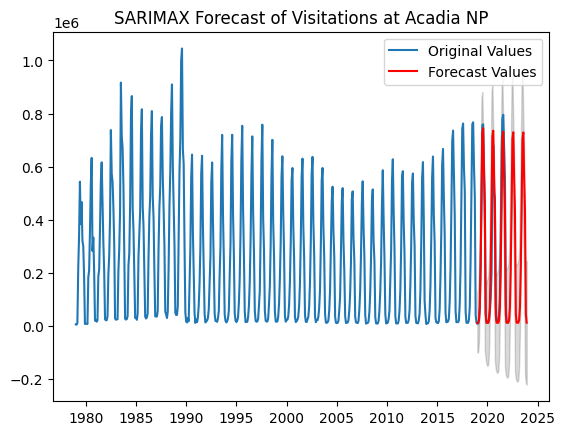

In [122]:
# Plot
plt.plot(df_ori[df_ori.Name == "Acadia NP"]["Visit"], label = "Original Values")


plt.plot(aca_forecast["Visit_Forecast"], color= 'r', label = "Forecast Values")
plt.fill_between(aca_forecast.index, 
                 aca_forecast.LCI, 
                 aca_forecast.UCI, 
                 color = 'k', alpha=.15)
plt.legend()

plt.title("SARIMAX Forecast of Visitations at Acadia NP")
plt.savefig(r"F:\CSE 6242\Project\Viz\Forecast_Acadia_Sarimax.png", dpi = 300)